# Arbeitsblatt 2: Lineare Regression, Eigengesichter und Bayes-Klassifikator

## 1. Linear Regression on Fish Data

The following data-set contains the number of fish groups of camper caught in a state park (taken from https://stats.idre.ucla.edu/r/dae/zip/). Your task here is to predict the number of fish caught by a fishing party from the following information: 

* how many people are in the group
* the number children in the group
* the use of live bait
* whether the group came with a camper to the park. 

We have a small data set, of 250 groups, which visited a state park and provided. For comparison the data set is already split into a training set and testset.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import scipy.stats as stats
import tensorflow as tf
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')
Xt = d['Xt'] #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
pd.DataFrame(Xt[0:2])

Downloading


('fishing.npz', <http.client.HTTPMessage at 0x20b721a0d30>)

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


a) Do a linear regression by creating a design matrix with the intercept term and use the fomulae given in the lecture to determine the coefficients on the training set.

In [4]:
#X = np.hstack((Xt, np.ones((Xt.shape[0], 1))))
#w = np.power(X.T@X, -1)@X.T@yt
#np.dot(X, np.array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051]))
#y_hat = X * w
#y_hat

b) Repeat a) but this time with `LinearRegression` from `sklearn.linear_model`

Result: array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])
Don't forget the intercept, you should have 5 numbers!

In [9]:
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(Xt, yt)
coefficients = reg.coef_
intercept = reg.intercept_
np.insert(coefficients, 0, intercept)

LinearRegression()

array([-8.492233 ,  2.4822135,  2.9543087,  4.649542 , -5.471604 ],
      dtype=float32)

c) Determine the Root Mean Square Error (RMSE) and the average negative log-likelihood (NLL) on the testset. For NLL we assume that the conditional probability distrubution (CPD) $p(y|x)$ is given by the density of a Gaussian with constant variance $\sigma^2$. Estimate $\sigma^2$ using the variance of the residuals. Use the variance estimation with $1/N$. 

Result: $ RMSE \approx 8.58812$, $\hat \sigma^2 \approx 73.7559$, $\tt{NLL} \approx 3.569$

In [49]:
yPrediction = reg.predict(Xt)
difference = yt - yPrediction
variance  = np.var(difference)
rmse = np.sqrt(variance)

sorted = np.sort(difference)[:-1]
sd = np.std(sorted)
mean = np.mean(sorted)
distribution = stats.norm(mean, sd)
probs = list(map(distribution.pdf, sorted))
logProbs = np.log(probs)
nll = -np.mean(logProbs)

print("variance:", variance)
print("nll:", nll)
print("rmse:", rmse)
# TODO ERGEBNIS STIMMT NICHT

variance: 117.26951
nll: 3.0833759142583004
rmse: 10.829104


d) For the testset: plot the predicted mean number of fish caught ($\mu$) against observed number of fish caught. Further include the 2.5 and 97.5 precentile of p(y|x), the conditional predictive distribution (CPD) of $y$ for a given $x$. Why is a Gaussian not ideal for that kind of data? 

Hint: For the Gaussian the 2.5% and the 97.5% percentile is approximatiy given by $\mu \pm 1.96*\sigma$

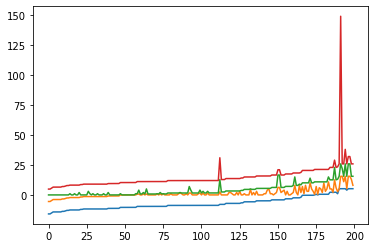

In [14]:
upper = yPrediction + (1.96 * sd)
lower = yPrediction - (1.96 * sd)
yData = np.c_[yt, lower, yPrediction, upper]
toPlot = yData[yData[:, 2].argsort()]
plt.plot(np.sort(toPlot))

e) This data is count data. Count data has only positive values and also the distribution is discrete. You cannot catch 0.5 fish and that the CPD has probability density > 0 on negative number of fish is wrong too. A Gaussian as a CPD is therefore not ideal. 

Now use a Poissonian as CPD. If we assume a Poissonian then the probability to catch $k$ fish is given by 
$$
  p(k) = \exp(-\mu) \frac{\mu^k}{k!}
$$

and the NLL is thus by:

$$
 log(p(k)) = -\mu  + k \cdot \log(\mu) - log(k!)
$$

with $\mu$ being the expectation. In our case the average number of fish expected.

In the case of the probabilistic interpretation of the linear regression, $y_i$ for a given $x_i$ is distributed like a Gaussian. The paramter $\mu_i$ from $N(\mu_i,\sigma^2)$ has been determined from $x_i$ via $\mu_i= \beta^T \cdot x_i$ by minimizing the NLL. 

A small additional detail: For the Poissonian case, $\mu_i$ needs to be positive. We therefore do not use $\beta^T \cdot x_i$ directly but "pipe it through" an exponential first to make it positive and thus link $\mu_i=exp(\beta^T \cdot x_i)$ to the data.

Use a gradient descent approach on the NLL to find the solution for the parameters. Calculate the RMSE and the NLL on the test set and compare with c).

Hint: On the trainingset for the parameter values (1,1,1,1,1) the NLL should be approx 1508 and the gradient (1518.61, 1403.99, 1171.02, 5701.91, 3258.7). For the NLL a good learning rate would be 0.001 and training should be done for at least 5000 epochs.

In [122]:
def calculate_expected(x, b):
    raw = np.matmul(x, b[:-1]) + b[-1]
    return np.exp(raw)

def calculate_nll(x, y, b):
    expected = calculate_expected(x, b)
    factorials = list(map(np.math.factorial, y.astype(int)))
    nlls = expected - y * np.log(expected) + np.log(factorials)
    return nlls

calculate_loss = lambda  b: calculate_nll(Xt, yt.astype(int), b)

np.mean(calculate_loss([1, 1, 1, 1, 1]))

TypeError: loop of ufunc does not support argument 0 of type int which has no callable log method

In [123]:
X = np.c_[np.ones(Xt.shape[0]), Xt]
w = tf.reshape(np.ones(5).astype(int), shape = [5,1])

Xs = tf.Variable(np.asmatrix(X,dtype='double'))
ws = tf.Variable(np.asarray(w,dtype='double'))
for i in range(5):
    with tf.GradientTape() as tape: #Mechanism to store gradients
        tape.watch(ws)
        y_hat = tf.matmul(Xs,ws)
        loss = tf.reduce_mean(calculate_loss(ws)) #MSE
        if (i % 500 == 0):
            print(i, "  ",ws.numpy().T,'  ',loss.numpy())
        grads = tape.gradient(loss, ws) #gradient wrt w
        print(grads)
        # TODO GRADIENT FUNKTIONIERT NICHT
        #ws = tf.Variable(ws - 0.001 * grads)

TypeError: loop of ufunc does not support argument 0 of type int which has no callable log method

In [129]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


In [55]:
nll = np.mean(calculate_loss(ws))
print("nll:", nll)

yPrediction = calculate_expected(Xt, ws)
difference = yt - yPrediction
variance  = np.var(difference)
rmse = np.sqrt(variance)
print("rmse:", rmse)

nll: 1510.1271602262084
rmse: 3508.3136662823117


f) Do the same plot as in d) but this time with a Poisson CPD. Hint you can use scipy.stats.poisson to calculate the percentiles.

array([0., 0., 0., 1., 1.])

array([ 3.,  5.,  7.,  8., 10.])

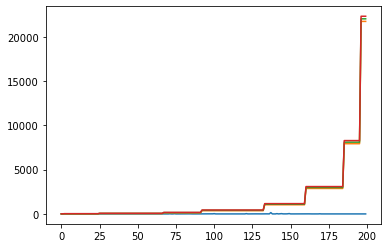

In [131]:
calc = lambda p, y: stats.poisson(y).ppf(p)
calcLower = lambda y: calc(0.025, y)
calcUpper = lambda y: calc(0.975, y)

lower = list(map(calcLower, yPrediction))
upper = list(map(calcUpper, yPrediction))
yData = np.c_[yt, lower, yPrediction, upper]
toPlot = yData[yData[:, 2].argsort()]
plt.plot(np.sort(toPlot))
calcLower([1, 2, 3, 4, 5])
calcUpper([1, 2, 3, 4, 5])


## 2. Eigengesichter
Die Hauptkomponentenanalyse lässt sich auch auf Bilder anwenden, indem man die Bildzeilen in einem einzigen Vektor aneinander hängt (*Stacking*). Die zugehörigen Richtungen extremaler Varianz heißen *Eigengesichter*. Sie eignen sich nicht nur zur Datenkompression, sondern auch zum Aufbau eines einfachen Gesichtserkennungssystems (s. M. Turk and A. Pentland, “Eigenfaces for Recognition”, Journal of Cognitive Neuroscience, vol. 3, no. 1, pp. 71–86, 1991). Für die Funktion eines solchen Systems ist es wichtig, dass die Gesichter zentriert und in derselben Größe abgebildet sind. Ein dafür geeigneter Datensatz ist ''Labeled Faces in the Wild'' der Universität von Massachusetts in Amherst (`http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz`, 233MB) mit Bildern von 13.000 Personen des öffentlichen Lebens aus dem Internet, alle mit Namen gelabelt.

Aufgaben:

a) Laden Sie sich den oben angegebenen Datensatz herunter. Erstellen Sie ein Python- Skript, dass die Verzeichnisse des Datensatzes durchsucht und die Personen ermittelt, für die mindestens 70 Bilder existieren. Die dafür geeigneten Funktionen finden sich im Standardmodul `os` bzw. `os.path`.

In [ ]:
import tarfile, os

#the 'lfw-funneled.tgz' file has to be in the 'uebungen'-directory 

if not os.path.exists('./exercise2_faces'):
    file = tarfile.open('lfw-funneled.tgz')
    file.extractall('./exercise2_faces')
    file.close()


In [ ]:

path = 'exercise2_faces/lfw_funneled'
persons = []
total_count = 0
for dir in os.listdir(path):
    if os.path.isdir(path + "/" + dir):
        i = 0
        for name in os.listdir(path + "/" + dir):
                i += 1
        if i >= 70:
            persons.append(dir)
            total_count += i
persons    

b) Erstellen Sie ein Python-Skript, das alle Bilder bis auf eines pro Person (diese werden später zum Testen des Klassifikators gebraucht) dieser am häufigsten abgebildeten Personen lädt, diese in Vektoren stackt und dann in einer gemeinsamen Designmatrix ablegt. Zum Laden der Bilder in Numpy-Arrays verwenden Sie am einfachsten das Modul `scikit-image`. Schneiden Sie zunächst einen einheitlichen zentralen Ausschnitt aus, der nur Augen und Mund enthält. Skalieren Sie die Bilder auf die Größe 32 × 32. Achten Sie darauf, vorher die Farbbilder in Grauwerte umzuwandeln (z.B. mit der Option `as_gray = True`) Legen Sie zusätzlich einen Vektor an, in dem der Name der Person (d.h. der Ordnername) für jede Zeile steht. Führen Sie die gleiche Art der Verarbeitung mit dem übrig gebliebenen Testbild pro Person durch und speichern Sie diese getrennt ab.

In [ ]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rescale

training_images = []
test_images = []
test_names = []
training_names = []

for person in persons:
    for picture in os.listdir(path + "/" + person):
        img = io.imread(path + "/" + person + "/" + picture, as_gray = True).flatten()
        training_images.append(img)
        training_names.append(person)
    
    test_images.append(training_images.pop())
    test_names.append(training_names.pop())
    #test_images.append(training_images[-1])
    #test_names.append(training_names[-1])


In [ ]:
np_training_images = np.array(training_images)
np_test_images = np.array(test_images)

test_arr = []
training_arr = []
cropped_x = [85, 165]
cropped_y = [95,175]

for image in np_test_images:
    cropped = image.reshape(250, 250)[cropped_y[0] : cropped_y[1], cropped_x[0] : cropped_x[1]]
    scaled = rescale(cropped, scale = 32 / cropped.shape[0])
    test_arr.append(scaled.flatten())

for image in np_training_images:
    cropped = image.reshape(250, 250)[cropped_y[0] : cropped_y[1], cropped_x[0] : cropped_x[1]]
    scaled = rescale(cropped, scale = 32 / cropped.shape[0])
    training_arr.append(scaled.flatten())

np_sc_training_arr = np.array(training_arr)
np_sc_test_arr = np.array(test_arr)



c) Wenden Sie nun Ihre Hauptkomponentenanalyse aus Arbeitsblatt 1 auf Ihre Designmatrix (Achtung: kopieren Sie alle Trainingsbilder für alle Personen als Zeilen in eine gemeinsame Designmatrix!) an. Stellen Sie die ersten 150 Eigenwerte in einem Diagramm und die ersten 12 Eigengesichter durch Umformung der gestackten Darstellung in das ursprüngliche Bildformat
dar. Interpretieren Sie das Ergebnis.

In [ ]:
import pca

X, U, D, Vt, pc, a, std = pca.calc2(np_sc_training_arr, 12)

eigenvalues = np.square(D) / (len(np_sc_training_arr) - 1)

plt.scatter(np.arange(150), eigenvalues[:150])

fig = plt.figure(figsize=(20,14))
rows = 4
cols = 3

for i in range (0, len(pc)):
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(pc[i].reshape(32,32), cmap = "gray")
    plt.title(str(i + 1) + ". Hauptkomponente")    



d. Von den Testbildern wird nun ebenfalls der Mittelwert der Trainingsdaten abgezogen (s. Schritt 1 im PCA-Algorithmus). Projizieren Sie jedes der Trainings- und Testbilder auf die ersten 7 Eigengesichter, d.h. Sie erhalten so für jedes Trainings- und Testbild 7 Merkmale. Die Gesichtserkennung geschieht nun dadurch, dass Sie den euklidischen Abstand des Testbildes in diesem 7-dimensionalen Merkmalsraum zu allen Trainingsbildern berechnen. Die Person des am nächsten liegenden Trainingsbildes (d.h. mit dem minimalen euklidischen Abstand) ist dann (vermutlich) auch die korrekte Person für das Testbild (Nächster-Nachbar-Klassifikator). Welche Bilder werden korrekt klassifiziert, welche Verwechslungen gibt es?

In [ ]:
test_centered = (np_sc_test_arr - np.mean(np_sc_training_arr)) / np.std(np_sc_training_arr)

X, U, D, Vt, pc, a, std = pca.calc2(np_sc_training_arr, 7)
a_training = a
a_test = (test_centered @ pc.T)

min_distances = []
estimated_persons = []
estimated_index = []
i = 0

for projected_test_image in a_test:
    j = 0
    min_distances.append(np.Inf)
    estimated_persons.append("")
    estimated_index.append(-1)
    for projected_training_image in a_training:
        distance = np.linalg.norm(projected_test_image - projected_training_image)
        if distance < min_distances[i]:
            min_distances[i] = distance
            estimated_persons[i] = training_names[j]
            estimated_index[i] = j
        j += 1
    i += 1

estimated_persons
print("-----------------")
test_names

In [ ]:
fig = plt.figure(figsize = (10, 30))

for i in range(0, 7):
    ax1 = fig.add_subplot(7,2, 2*i+1)
    ax1.imshow(np_sc_test_arr[i].reshape(32,32), cmap = "gray")
    plt.title("test image")
    ax2 = fig.add_subplot(7,2,2*i+2)
    ax2.imshow(np_sc_training_arr[estimated_index[i]].reshape(32,32), cmap = "gray")
    plt.title("ED = " + str(min_distances[i]))


## 3. Naiver Bayesklassifikator zur Gesichtserkennung
Implementieren Sie den Gaussian-Naïve-Bayes-Klassifikator aus der Vorlesung. Testen Sie Ihre Implementierung am Datensatz ''Labeled Faces in the Wild'' aus Aufgabe 2, wiederum nur für Personen, für die mindestens 70 Bilder existieren. Teilen Sie Ihren Datensatz in 60 % Trainings- und 40% Testdaten (nach vorheriger Zufalls-Permutation der Reihenfolge) und skalieren Sie die Bilder wieder auf 1/8 der Originalgröße. Führen Sie anschließend eine Hauptkomponentenanalyse auf den Trainingsdaten durch und projizieren Sie sowohl Trainings- als auch Testbilder auf die ersten 7 Eigengesichter. Trainieren Sie Ihren GNB-Klassifikator auf dem Trainingsdatensatz als ''George-W.-Bush-Detektor'', d.h. alle zu dieser Person gehörigen Bilder werden mit 1 gelabelt, alle sonstigen mit –1. Werten Sie Ihren Klassifikator sowohl auf den Trainings- wie auf den unabhängigen Testdaten aus. Bestimmen Sie dafür jeweils die Detektionswahrscheinlichkeit, Richtig-Negativ-Rate, Fehlalarmrate und Falsch-Negativ-Rate.
